<h1 align="center">COVID-19 Trends & Forecasts</h1>

<p>In this project, I will be experimenting with COVID-19 datasets with the following goals in mind:</p>
<ul>
    <li>Produce usefull visualizations, using Matplotlib, Seaborn and Plotly, to demonstrate trends and insights in the underlying datasets.</li>
    <li>Produce interactive maps using Folium.</li>
    <li>Forecast, using Facebook's Prophet, future trends in the COVID-19 pandemic</li>
</ul>

<p>Datasets Reference:</p>
<ul>
    <li>Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real time. Lancet Inf Dis. 20(5):533-534. doi: 10.1016/S1473-3099(20)30120-1</li>
</ul>

In [2]:
#Installing required packages
!pip install folium

     |████████████████████████████████| 95 kB 2.7 MB/s             
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.1.0 requires urllib3[secure]~=1.26, but you have urllib3 1.25.11 which is incompatible.


In [105]:
!pip install fbprophet

     |████████████████████████████████| 64 kB 3.5 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=723330 sha256=0f89963bb121b2af56d6e6c1650ccc5e9a14b61d50dd827ee32d7eee31b0be95
  Stored in directory: /Users/mario/Library/Caches/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.


In [205]:
#Importing required packages
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import plotly.express as px                 #visualisation
import plotly.graph_objects as go           #visualisation
import folium                               #visualisation - maps
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
#Defaults
plt.rcParams["figure.figsize"] = 13,7

## Data Cleaning

In [3]:
#Loading datasets
df_confirmed = pd.read_csv("time_series_covid19_confirmed_global_narrow.csv", 
                           low_memory=False)

df_deaths = pd.read_csv("time_series_covid19_deaths_global_narrow.csv", 
                           low_memory=False)

df_recovered = pd.read_csv("time_series_covid19_recovered_global_narrow.csv", 
                           low_memory=False)

In [4]:
#Rename columns
df_confirmed = df_confirmed.rename(columns={"Value":"Confirmed",
                                            "ISO 3166-1 Alpha 3-Codes":"Country Code"})

df_deaths = df_deaths.rename(columns={"Value":"Deaths",
                                            "ISO 3166-1 Alpha 3-Codes":"Country Code"})

df_recovered = df_recovered.rename(columns={"Value":"Recovered",
                                            "ISO 3166-1 Alpha 3-Codes":"Country Code"})

In [5]:
#Drop the first row because it's not needed
df_confirmed.drop([0], inplace=True)
df_deaths.drop([0], inplace=True) 
df_recovered.drop([0], inplace=True) 

In [6]:
#Change data types
df_confirmed = df_confirmed.astype({"Lat":float,
                                    "Long":float,
                                    "Confirmed":int})

df_confirmed["Date"] = pd.to_datetime(df_confirmed["Date"])

In [7]:
df_deaths = df_deaths.astype({"Lat":float,
                              "Long":float,
                              "Deaths":int})

df_deaths["Date"] = pd.to_datetime(df_deaths["Date"])

In [8]:
df_recovered = df_recovered.astype({"Lat":float,
                                    "Long":float,
                                    "Recovered":int})

df_recovered["Date"] = pd.to_datetime(df_recovered["Date"])

In [9]:
#Sort our dataframes by Country then by date
df_confirmed.sort_values(by=["Country/Region","Date"], inplace=True, ignore_index=True)
df_deaths.sort_values(by=["Country/Region","Date"], inplace=True, ignore_index=True)
df_recovered.sort_values(by=["Country/Region","Date"], inplace=True, ignore_index=True)

In [10]:
#Let's select some countries we're interested in
confirmed = df_confirmed.loc[df_confirmed['Country Code'] == "GBR"]\
                        .loc[df_confirmed['Province/State'].isna()].copy()
confirmed.reset_index(drop=True, inplace=True)

In [11]:
deaths = (df_deaths.loc[df_deaths['Country Code'] == "GBR"]\
                   .loc[df_deaths['Province/State'].isna()][["Deaths"]]).copy().astype(int)
deaths.reset_index(drop=True, inplace=True)

In [12]:
recovered = df_recovered.loc[df_recovered['Country Code'] == "GBR"]\
                        .loc[df_recovered['Province/State'].isna()][["Recovered"]].copy().astype(int)
recovered.reset_index(drop=True, inplace=True)

In [13]:
df_UK = pd.concat([confirmed,recovered,deaths], axis=1)

In [14]:
#Now we can drop some unwanted columns
df_UK = df_UK.drop(["Province/State","Country/Region","Country Code","Lat","Long",
                    "Region Code","Sub-region Code","Intermediate Region Code"], axis=1)

In [54]:
df_UK.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


In [17]:
#Let's select some countries we're interested in
confirmed = df_confirmed.loc[df_confirmed['Country Code'] == "USA"]\
                        .loc[df_confirmed['Province/State'].isna()].copy()
confirmed.reset_index(drop=True, inplace=True)

In [18]:
deaths = df_deaths.loc[df_deaths['Country Code'] == "USA"]\
                  .loc[df_deaths['Province/State'].isna()][["Deaths"]].copy().astype(int)
deaths.reset_index(drop=True, inplace=True)

In [19]:
recovered = df_recovered.loc[df_recovered['Country Code'] == "USA"]\
                        .loc[df_recovered['Province/State'].isna()][["Recovered"]].copy().astype(int)
recovered.reset_index(drop=True, inplace=True)

In [20]:
df_USA = pd.concat([confirmed,recovered,deaths], axis=1)

In [21]:
df_USA = df_USA.drop(["Province/State","Country/Region","Country Code","Lat","Long",
                      "Region Code","Sub-region Code","Intermediate Region Code"], axis=1)

In [23]:
df_USA.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,1,0,0
1,2020-01-23,1,0,0
2,2020-01-24,2,0,0
3,2020-01-25,2,0,0
4,2020-01-26,5,0,0


In [24]:
#Let's select some countries we're interested in
confirmed = df_confirmed.loc[df_confirmed['Country Code'] == "EGY"]\
                        .loc[df_confirmed['Province/State'].isna()].copy()
confirmed.reset_index(drop=True, inplace=True)

In [25]:
deaths = df_deaths.loc[df_deaths['Country Code'] == "EGY"]\
                  .loc[df_deaths['Province/State'].isna()][["Deaths"]].copy().astype(int)
deaths.reset_index(drop=True, inplace=True)

In [26]:
recovered = df_recovered.loc[df_recovered['Country Code'] == "EGY"]\
                        .loc[df_recovered['Province/State'].isna()][["Recovered"]].copy().astype(int)
recovered.reset_index(drop=True, inplace=True)

In [27]:
df_EGY = pd.concat([confirmed,recovered,deaths], axis=1)

In [28]:
df_EGY = df_EGY.drop(["Province/State","Country/Region","Country Code","Lat","Long",
                      "Region Code","Sub-region Code","Intermediate Region Code"], axis=1)

In [30]:
df_EGY.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


In [31]:
#Let's select some countries we're interested in
confirmed = df_confirmed.loc[df_confirmed['Country Code'] == "ROU"]\
                        .loc[df_confirmed['Province/State'].isna()].copy()
confirmed.reset_index(drop=True, inplace=True)

In [32]:
deaths = df_deaths.loc[df_deaths['Country Code'] == "ROU"]\
                  .loc[df_deaths['Province/State'].isna()][["Deaths"]].copy().astype(int)
deaths.reset_index(drop=True, inplace=True)

In [33]:
recovered = df_recovered.loc[df_recovered['Country Code'] == "ROU"]\
                        .loc[df_recovered['Province/State'].isna()][["Recovered"]].copy().astype(int)
recovered.reset_index(drop=True, inplace=True)

In [34]:
df_ROU = pd.concat([confirmed,recovered,deaths], axis=1)

In [35]:
df_ROU = df_ROU.drop(["Province/State","Country/Region","Country Code","Lat","Long",
                      "Region Code","Sub-region Code","Intermediate Region Code"], axis=1)

In [37]:
df_ROU.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


In [38]:
#Let's select some countries we're interested in
confirmed = df_confirmed.loc[df_confirmed['Country Code'] == "ITA"]\
                        .loc[df_confirmed['Province/State'].isna()].copy()
confirmed.reset_index(drop=True, inplace=True)

In [39]:
deaths = df_deaths.loc[df_deaths['Country Code'] == "ITA"]\
                  .loc[df_deaths['Province/State'].isna()][["Deaths"]].copy().astype(int)
deaths.reset_index(drop=True, inplace=True)

In [40]:
recovered = df_recovered.loc[df_recovered['Country Code'] == "ITA"]\
                        .loc[df_recovered['Province/State'].isna()][["Recovered"]].copy().astype(int)
recovered.reset_index(drop=True, inplace=True)

In [41]:
df_ITA = pd.concat([confirmed,recovered,deaths], axis=1)

In [42]:
df_ITA = df_ITA.drop(["Province/State","Country/Region","Country Code","Lat","Long",
                      "Region Code","Sub-region Code","Intermediate Region Code"], axis=1)

In [43]:
df_ITA.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


In [44]:
#Let's select some countries we're interested in
confirmed = df_confirmed.loc[df_confirmed['Country Code'] == "IND"]\
                        .loc[df_confirmed['Province/State'].isna()].copy()
confirmed.reset_index(drop=True, inplace=True)

In [45]:
deaths = df_deaths.loc[df_deaths['Country Code'] == "IND"]\
                  .loc[df_deaths['Province/State'].isna()][["Deaths"]].copy().astype(int)
deaths.reset_index(drop=True, inplace=True)

In [46]:
recovered = df_recovered.loc[df_recovered['Country Code'] == "IND"]\
                        .loc[df_recovered['Province/State'].isna()][["Recovered"]].copy().astype(int)
recovered.reset_index(drop=True, inplace=True)

In [47]:
df_IND = pd.concat([confirmed,recovered,deaths], axis=1)

In [48]:
df_IND = df_IND.drop(["Province/State","Country/Region","Country Code","Lat","Long",
                      "Region Code","Sub-region Code","Intermediate Region Code"], axis=1)

In [49]:
df_IND.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


In [61]:
#Now let's convert out dataframes into time series by reseting the index to the date column
ts_UK  = df_UK.set_index("Date")
ts_USA = df_USA.set_index("Date")
ts_EGY = df_EGY.set_index("Date")
ts_ROU = df_ROU.set_index("Date")
ts_ITA = df_ITA.set_index("Date")
ts_IND = df_IND.set_index("Date")

In [51]:
#Let's save the coordiantes for fututre use
UK_coordinates = (55.3781,-3.436)
USA_coordinates = (40.0,-100.0)
EGY_coordinates = (26.820553,30.802498)
ROU_coordinates = (45.9432,24.9668)
ITA_coordinates = (41.87194,12.56738)
IND_coordinates = (41.87194,12.56738)

In [100]:
ts_UK.Recovered.astype(bool).sum(axis=0)

61

## Data Exploration

### UK

In [89]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_UK.index.date,
                         y=ts_UK["Confirmed"],
                         mode="lines+markers",
                         line_color="blue",
                         name="Confirmed"))

fig.add_trace(go.Scatter(x=ts_UK.index.date,
                         y=ts_UK["Recovered"],
                         mode="lines+markers",
                         line_color="green",
                         name="Recovered"))

fig.add_trace(go.Scatter(x=ts_UK.index.date,
                         y=ts_UK["Deaths"],
                         mode="lines+markers",
                         line_color="red",
                         name="Deaths"))

fig.update_layout(title_text="COVID-19 Cases in the United Kingdom", plot_bgcolor='rgb(230,230,230)')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [95]:
fig = px.bar(ts_UK, x=ts_UK.index.date, y="Confirmed", color="Confirmed", orientation="v", height=600,
             title="COVID-19 Confirmed cases in the United Kingdom", 
             color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

### USA

In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_USA.index.date,
                         y=ts_USA["Confirmed"],
                         mode="lines+markers",
                         line_color="blue",
                         name="Confirmed"))

fig.add_trace(go.Scatter(x=ts_USA.index.date,
                         y=ts_USA["Recovered"],
                         mode="lines+markers",
                         line_color="green",
                         name="Recovered"))

fig.add_trace(go.Scatter(x=ts_USA.index.date,
                         y=ts_USA["Deaths"],
                         mode="lines+markers",
                         line_color="red",
                         name="Deaths"))

fig.update_layout(title_text="COVID-19 Cases in the United States", plot_bgcolor='rgb(230,230,230)')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [96]:
fig = px.bar(ts_USA, x=ts_USA.index.date, y="Confirmed", color="Confirmed", orientation="v", height=600,
             title="COVID-19 Confirmed cases in the United States", 
             color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

### Egypt

In [91]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_EGY.index.date,
                         y=ts_EGY["Confirmed"],
                         mode="lines+markers",
                         line_color="blue",
                         name="Confirmed"))

fig.add_trace(go.Scatter(x=ts_EGY.index.date,
                         y=ts_EGY["Recovered"],
                         mode="lines+markers",
                         line_color="green",
                         name="Recovered"))

fig.add_trace(go.Scatter(x=ts_EGY.index.date,
                         y=ts_EGY["Deaths"],
                         mode="lines+markers",
                         line_color="red",
                         name="Deaths"))

fig.update_layout(title_text="COVID-19 Cases in Egypt", plot_bgcolor='rgb(230,230,230)')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [97]:
fig = px.bar(ts_EGY, x=ts_EGY.index.date, y="Confirmed", color="Confirmed", orientation="v", height=600,
             title="COVID-19 Confirmed cases in Egypt", 
             color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

### Romania

In [92]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_ROU.index.date,
                         y=ts_ROU["Confirmed"],
                         mode="lines+markers",
                         line_color="blue",
                         name="Confirmed"))

fig.add_trace(go.Scatter(x=ts_ROU.index.date,
                         y=ts_ROU["Recovered"],
                         mode="lines+markers",
                         line_color="green",
                         name="Recovered"))

fig.add_trace(go.Scatter(x=ts_ROU.index.date,
                         y=ts_ROU["Deaths"],
                         mode="lines+markers",
                         line_color="red",
                         name="Deaths"))

fig.update_layout(title_text="COVID-19 Cases in Romania", plot_bgcolor='rgb(230,230,230)')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [101]:
fig = px.bar(ts_ROU, x=ts_ROU.index.date, y="Confirmed", color="Confirmed", orientation="v", height=600,
             title="COVID-19 Confirmed cases in Romania", 
             color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

### Italy

In [93]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_ITA.index.date,
                         y=ts_ITA["Confirmed"],
                         mode="lines+markers",
                         line_color="blue",
                         name="Confirmed"))

fig.add_trace(go.Scatter(x=ts_ITA.index.date,
                         y=ts_ITA["Recovered"],
                         mode="lines+markers",
                         line_color="green",
                         name="Recovered"))

fig.add_trace(go.Scatter(x=ts_ITA.index.date,
                         y=ts_ITA["Deaths"],
                         mode="lines+markers",
                         line_color="red",
                         name="Deaths"))

fig.update_layout(title_text="COVID-19 Cases in Italy", plot_bgcolor='rgb(230,230,230)')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [102]:
fig = px.bar(ts_ITA, x=ts_ITA.index.date, y="Confirmed", color="Confirmed", orientation="v", height=600,
             title="COVID-19 Confirmed cases in Italy", 
             color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

### India

In [94]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_IND.index.date,
                         y=ts_IND["Confirmed"],
                         mode="lines+markers",
                         line_color="blue",
                         name="Confirmed"))

fig.add_trace(go.Scatter(x=ts_IND.index.date,
                         y=ts_IND["Recovered"],
                         mode="lines+markers",
                         line_color="green",
                         name="Recovered"))

fig.add_trace(go.Scatter(x=ts_IND.index.date,
                         y=ts_IND["Deaths"],
                         mode="lines+markers",
                         line_color="red",
                         name="Deaths"))

fig.update_layout(title_text="COVID-19 Cases in India", plot_bgcolor='rgb(230,230,230)')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [103]:
fig = px.bar(ts_IND, x=ts_IND.index.date, y="Confirmed", color="Confirmed", orientation="v", height=600,
             title="COVID-19 Confirmed cases in India", 
             color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

### Forecasting

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [123]:
#I choose to create a new set of dataframes to be used for forecasting that meet Prophet's input requirements
fbp_confirmed_UK = df_UK[["Date","Confirmed"]].copy()
fbp_deaths_UK = df_UK[["Date","Deaths"]].copy()
fbp_recovered_UK = df_UK[["Date","Recovered"]].copy()

In [124]:
fbp_confirmed_UK.columns = ["ds","y"]
fbp_deaths_UK.columns = ["ds","y"]
fbp_recovered_UK.columns = ["ds","y"]

In [125]:
fbp_confirmed_UK["ds"] = pd.to_datetime(fbp_confirmed_UK["ds"])
fbp_deaths_UK["ds"] = pd.to_datetime(fbp_deaths_UK["ds"])
fbp_recovered_UK["ds"] = pd.to_datetime(fbp_recovered_UK["ds"])

In [154]:
fbp_recovered_UK.tail()

,ds,y
701,2021-12-23,0
702,2021-12-24,0
703,2021-12-25,0
704,2021-12-26,0
705,2021-12-27,0


#### Confirmed Cases in the UK

In [199]:
# I will use the population of the UK as the maximum achievable point.
# This is a Prophet requirement when forecasting growth
fbp_confirmed_UK["cap"] = 68418899
fbp_confirmed_UK["floor"] = 0

In [200]:
# Now let's do an initial forecast to build a base model
model = Prophet(growth="logistic", interval_width=0.95)
model.fit(fbp_confirmed_UK)
future = model.make_future_dataframe(periods=365)
future.tail(365)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
706,2021-12-28
707,2021-12-29
708,2021-12-30
709,2021-12-31
710,2022-01-01
...,...
1066,2022-12-23
1067,2022-12-24
1068,2022-12-25
1069,2022-12-26


In [201]:
future["cap"] = 68418899
future["floor"] = 0
forecast = model.predict(future)

In [202]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,38374.965211,-114310.865101,171691.279875
1,2020-01-23,40978.821128,-102377.108395,188892.406452
2,2020-01-24,43355.905148,-97507.171578,179291.838395
3,2020-01-25,43145.755875,-98574.482504,192503.952834
4,2020-01-26,42325.351624,-95763.936112,190864.779829


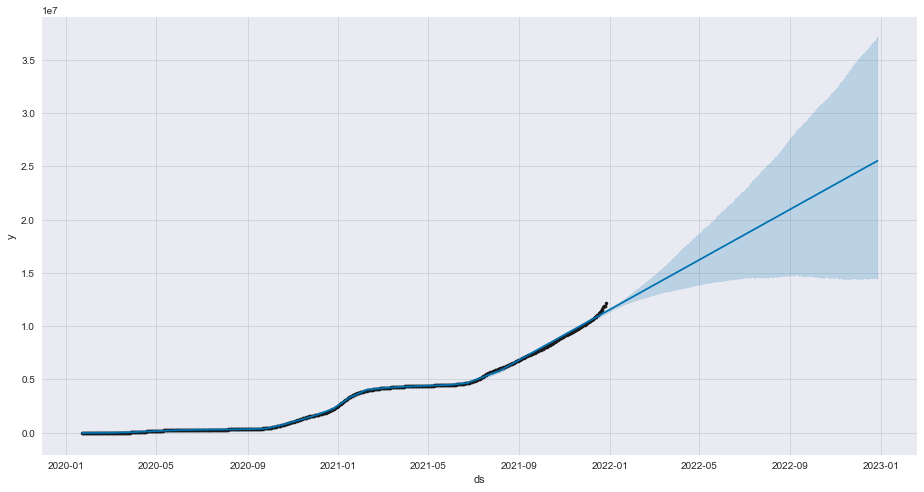

In [132]:
confirmed_forecast_plot = model.plot(forecast, figsize=(13,7))

In [204]:
fig = go.Figure([go.Scatter(x=fbp_confirmed_UK["ds"],
                         y=fbp_confirmed_UK["y"],
                         mode="markers",
                         line_color="black",
                         name="Historical"),

                 go.Scatter(x=forecast["ds"],
                         y=forecast["yhat"],
                         mode="lines",
                         line_color="green",
                         name="Forecast"),

                 go.Scatter(x=forecast["ds"],
                         y=forecast["yhat"]+forecast["yhat_upper"],
                         fill='tonexty',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         hoverinfo="skip",
                         showlegend=True,
                         name="Upper limit"),

                 go.Scatter(x=forecast["ds"],
                         y=forecast["yhat"]-abs(forecast["yhat_lower"]),
                         fill='tonexty',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         hoverinfo="skip",
                         showlegend=True,
                         name="Lower limit")
                ])



fig.update_layout(title_text="COVID-19 Confirmed Cases in the UK - Forecast", 
                  plot_bgcolor='rgb(230,230,230)',
                  hovermode="x")
fig.show()

## Deaths in the UK

In [139]:
# Now let's do an initial forecast to build a base model
model = Prophet(interval_width=0.50)
model.fit(fbp_deaths_UK)
future = model.make_future_dataframe(periods=365)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [140]:
forecast = model.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
1066,2022-12-23,195656.221701,84750.819523,317331.637538
1067,2022-12-24,195791.040267,84739.670078,318907.448031
1068,2022-12-25,195823.108919,84519.251047,318777.303689
1069,2022-12-26,195844.608158,84274.613283,319540.941451
1070,2022-12-27,196044.456441,83883.825524,319616.336546


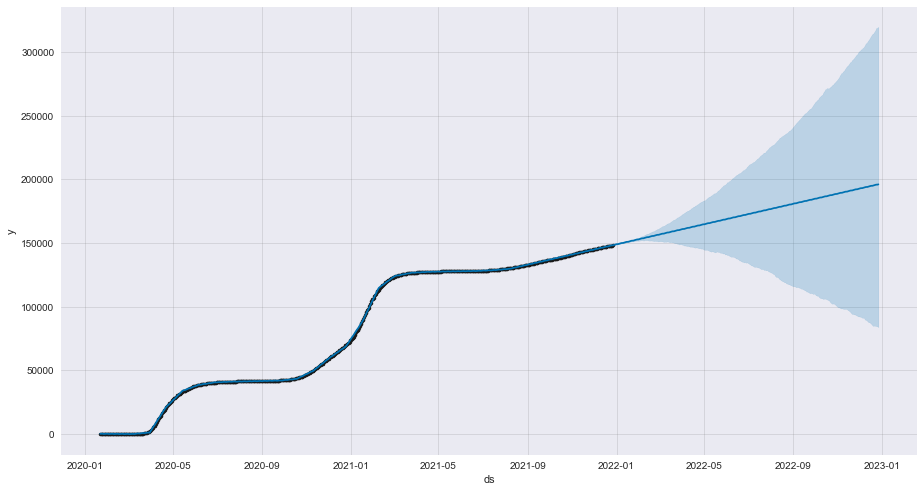

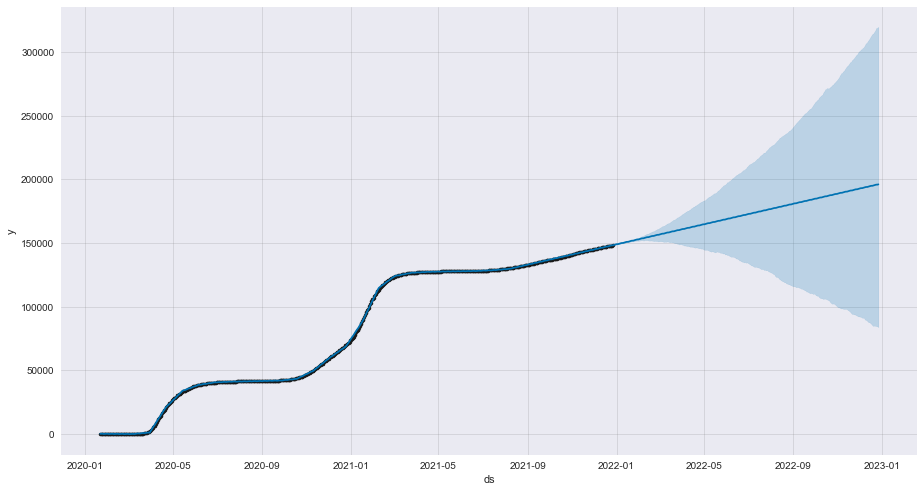

In [141]:
model.plot(forecast, figsize=(13,7))

#### Recovered cases in the UK

JHU has stopped reporting recovered cases so i would like to find the last reported recovered cases and forecast from that date onwards

In [164]:
max(i for i in fbp_recovered_UK.index.values if fbp_recovered_UK[["y"]].iloc[i].values != 0)

81

In [175]:
#Last reported Recoveries case was on the 12th of April 2020, so i want to drop all rows after that date
fbp_recovered_UK.drop(fbp_recovered_UK.index[82:],axis=0,inplace=True)

In [176]:
fbp_recovered_UK.tail()

,ds,y
77,2020-04-08,135
78,2020-04-09,135
79,2020-04-10,344
80,2020-04-11,344
81,2020-04-12,344


In [177]:
# Now let's do an initial forecast to build a base model
model = Prophet(interval_width=0.50)
model.fit(fbp_recovered_UK)
future = model.make_future_dataframe(periods=993)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [178]:
forecast = model.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
1070,2022-12-27,5541.992438,3857.608657,7442.228681
1071,2022-12-28,5547.244088,3823.481269,7449.316959
1072,2022-12-29,5550.029120,3836.195784,7469.178458
1073,2022-12-30,5570.230636,3869.284326,7484.866080
1074,2022-12-31,5573.848289,3867.338375,7496.013235


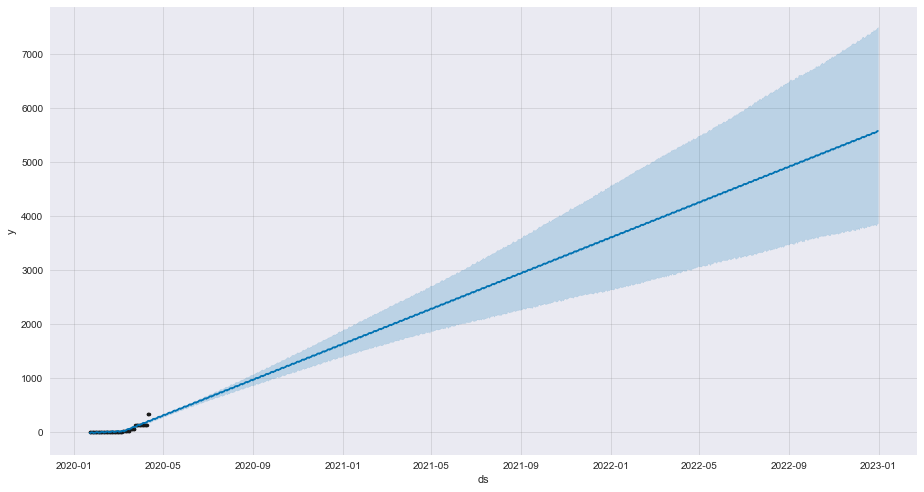

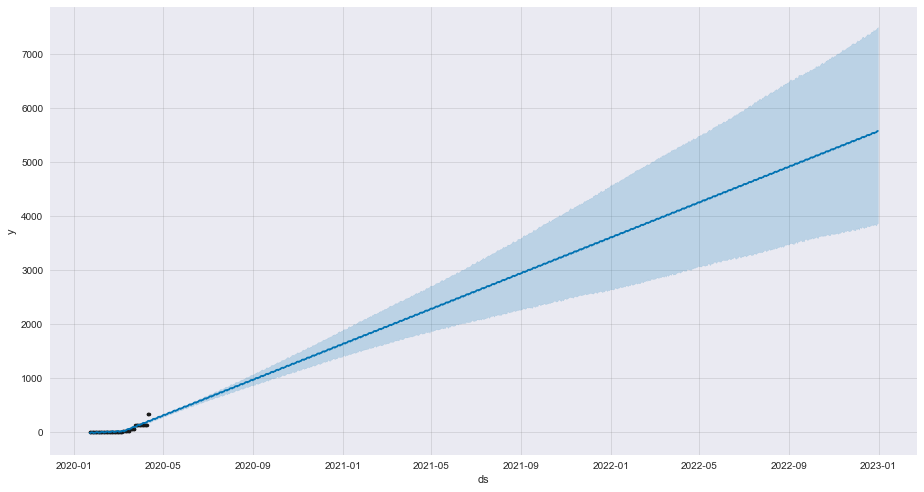

In [179]:
model.plot(forecast, figsize=(13,7))

In [188]:
fig = go.Figure([go.Scatter(x=fbp_recovered_UK["ds"],
                         y=fbp_recovered_UK["y"],
                         mode="markers",
                         line_color="black",
                         name="Historical"),

                 go.Scatter(x=forecast["ds"],
                         y=forecast["yhat"],
                         mode="lines",
                         line_color="green",
                         name="Forecast"),

                 go.Scatter(x=forecast["ds"],
                         y=forecast["yhat"]+forecast["yhat_upper"],
                         fill='tonexty',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         hoverinfo="skip",
                         showlegend=True,
                         name="Upper limit"),

                 go.Scatter(x=forecast["ds"],
                         y=forecast["yhat"]-forecast["yhat_lower"],
                         fill='tonexty',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         hoverinfo="skip",
                         showlegend=True,
                         name="Lower limit")
                ])



fig.update_layout(title_text="COVID-19 Recovered Cases in the UK - Forecast", 
                  plot_bgcolor='rgb(230,230,230)',
                  hovermode="x")
fig.show()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-12-27 00:00:00 and 2020-12-27 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,1.289096e+10,113538.359818,94038.158440,0.028441,0.028041,0.916667
1,37 days,1.581136e+10,125743.224439,101194.606807,0.029944,0.028041,0.888889
2,38 days,1.965884e+10,140209.970288,110013.342038,0.031955,0.029301,0.861111
3,39 days,2.453808e+10,156646.343589,120422.559740,0.034428,0.032718,0.833333
4,40 days,3.060431e+10,174940.864989,132579.539919,0.037412,0.035242,0.805556


,horizon,mse,rmse,mae,mape,mdape,coverage
325,361 days,2.610282e+15,5.109092e+07,5.108871e+07,4.846766,4.884158,0.0
326,362 days,2.614073e+15,5.112801e+07,5.112605e+07,4.823797,4.866593,0.0
327,363 days,2.617867e+15,5.116509e+07,5.116336e+07,4.801435,4.849061,0.0
328,364 days,2.621652e+15,5.120207e+07,5.120054e+07,4.779602,4.830265,0.0
329,365 days,2.624521e+15,5.123008e+07,5.122876e+07,4.754418,4.809515,0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



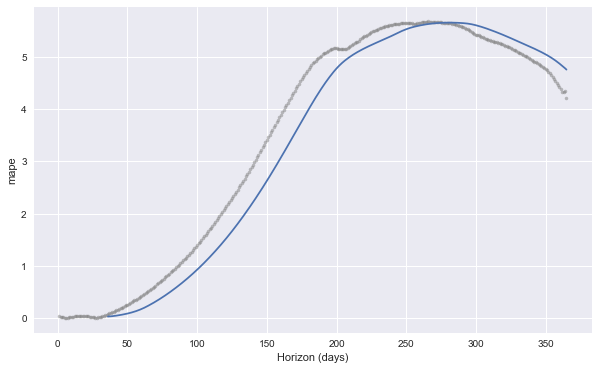

In [207]:
# Execute cross validation
df_cv = cross_validation(model, initial='180 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.show()